In [1]:
import string 
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import matplotlib.pyplot as plt

from keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from keras.utils import plot_model

# small library for seeing the progress of loops.
#from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm
tqdm().pandas()

0it [00:00, ?it/s]/usr/local/lib/python3.7/site-packages/tqdm/std.py:706: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [10]:
!pip3 show tensorflow

Name: tensorflow
Version: 2.1.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.7/site-packages
Requires: scipy, absl-py, numpy, keras-applications, gast, astor, tensorboard, opt-einsum, grpcio, google-pasta, wheel, protobuf, tensorflow-estimator, wrapt, six, keras-preprocessing, termcolor
Required-by: 


In [13]:
#!pip3 install --upgrade tensorflow 
!pip3 install --upgrade keras

Requirement already up-to-date: keras in /usr/local/lib/python3.7/site-packages (2.4.3)


In [43]:
!pip3 install swish-activation

Xception is a convolutional neural network that is 71 layers deep. You can load a pretrained version of the network trained on more than a million images from the ImageNet database. The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. As a result, the network has learned rich feature representations for a wide range of images. The network has an image input size of 299-by-299.

You can use classify to classify new images using the Xception model. 

In [3]:
PathText = '/Users/anjalisingh/Documents/ImageCaptionGenerator/Description_of_images/Flickr8k.token.txt'

In [4]:
imagePath = '/Users/anjalisingh/Documents/ImageCaptionGenerator/Flicker8k_Dataset'

In [5]:
# Loading a text file into memory Opening the file as read only
def load_doc(PathText):
    file = open(PathText, 'r')
    text = file.read()
    file.close()
    return text

TokenText = load_doc(PathText)

as we can see our text needs to split into different line to get the captions .Also over tab so that we can get description of the image corresponding to the respective image name. Let's make a function to do this 

In [15]:
# get all imgs with their captions 
def all_img_captions(PathText):
    captions = TokenText.split('\n')
    descriptions = {}
    for caption in captions[:-1]:          # all the captions in the list captions so we triversing through it
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:    
            # img contains name of the img#captionNumber caption number
            # represents the numberth of the caption of a particular image 
            # as an image contains 5 captions each. 
            # img[from starting: every character except for last 2 (#captionNumber)]
            descriptions[img[:-2]] = [caption]
        else:
            # arranging caption and img name accordingly 
            descriptions[img[:-2]].append(caption)
    return descriptions 

descriptions = all_img_captions(TokenText)

In [16]:
print("Length of descriptions =", len(descriptions))

Length of descriptions = 8092


In [11]:
table = str.maketrans('','', string.punctuation)

In [12]:
table

{33: None,
 34: None,
 35: None,
 36: None,
 37: None,
 38: None,
 39: None,
 40: None,
 41: None,
 42: None,
 43: None,
 44: None,
 45: None,
 46: None,
 47: None,
 58: None,
 59: None,
 60: None,
 61: None,
 62: None,
 63: None,
 64: None,
 91: None,
 92: None,
 93: None,
 94: None,
 95: None,
 96: None,
 123: None,
 124: None,
 125: None,
 126: None}

Data cleaning - converting to lower case, remove punctuations and word containing numbers

In [13]:
def cleaning_text(captions):
    table = str.maketrans('','', string.punctuation)
    for img, caps in captions.items():
        for i, img_caption in enumerate(caps):   
            # enumerate takes all the 5 captions of a particular 
            # image and gives then index from 0 to 4
            img_caption.replace("-"," ")
            desc = img_caption.split()
            # converts to lowercase
            desc = [word.lower() for word in desc]
            # remove punctuation from each token 
            desc = [word.translate(table) for word in desc]
            # remove hanging 's and a
            desc = [word for word in desc if(len(word)>1)]
            # remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            # convert back to string           
            img_caption = ' '.join(desc)

            captions[img][i] = img_caption
    return captions

clean_description = cleaning_text(descriptions)

In [14]:
print("Length of descriptions =", len(clean_description))

Length of descriptions = 8092


In [15]:
# build vocabulary of all the unique words
def text_vocabulary(descriptions):
    vocab = set()    # using set because it won't allow duplicate values
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab

vocabulary = text_vocabulary(clean_description)

In [14]:
def save_descriptions(descriptions, PathText):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc)
        data = "\n".join(lines)
        file = open(PathText, "w")
        file.write(data)
        file.close()


save_descriptions(clean_description, "descriptions.txt")
    

The function extract_features() will extract features for all images and we will map image names with their respective feature array. Then we will dump the features dictionary into a “features.p” pickle file.

Model intialization:
The important arg here is include_top=False which removes the fully connected layer at the end/top of the network. This allows us to get the feature vector as opposed to a classification.

Once initialised the model we can then pass it an image and use it to predict what it might be. However since we don’t want the prediction we instead will get a list of 2048 floating point values.

expand_dims() function. The expand_dims() function is used to expand the shape of an array. Insert a new axis that will appear at the axis position in the expanded array shape.

Python method listdir() returns a list containing the names of the entries in the directory given by path.

In [16]:
imagePath

'/Users/anjalisingh/Documents/ImageCaptionGenerator/Flicker8k_Dataset'

In [63]:
def extract_features(directory):
    model = Xception(include_top = False, pooling='avg')
    features = {}
    for img in tqdm(os.listdir(directory)):   # listing directories in images folder
        filename = directory + "/" + img
        image = Image.open(filename)
        image = image.resize((299, 299))
        # the image is now in an array of shape (3, 229, 229) 
        # need to expand it to (1, 3, 229, 229) as it's expecting a list
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        
        feature = model.predict(image)
        features[img] = feature
    return features

# 2048 feature vector
# features  = extract_features(imagePath)
# dump(features, open("features.p","wb"))    # features.p has been create which have image name and it's features.
# In a dictionary format image name is stored and its features as keys and every feature of a images are arranged in array

    

In [20]:
features = load(open("features.p", "rb"))

In [23]:
#os.listdir(imagePath)  # listing directories in images folder

In [24]:
for img in os.listdir(imagePath):
    filename = imagePath + "/" + img
    #print(filename)

In our description_of_image folder , we have 6000 images for training

In [7]:
trainText = '/Users/anjalisingh/Documents/ImageCaptionGenerator/Description_of_images/Flickr_8k.trainImages.txt'

In [8]:
# load the data
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos
train_imgs = load_photos(trainText)

In [9]:
# description.txt contains all the image name and description
# Now, by using this function we will take out the ones on which we need to train our model
def load_clean_descriptions(filename, photos):
    # loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):
        words = line.split()
        if len(words)<1:
            continue
        
        image, image_caption = words[0], words[1:]
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            
            desc = '<start>' + " ".join(image_caption) + '<end>'
            descriptions[image].append(desc)
            
    return descriptions

train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)

0it [00:52, ?it/s]


In [10]:
def load_features(photos):
    # loading all features
    all_features = load(open("features.p", "rb"))
    # selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features

train_features = load_features(train_imgs)

In [11]:
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

In [25]:
desc_list = dict_to_list(descriptions)
#desc_list

In [25]:
def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    # fit_on_texts: Updates internal vocabulary based on a list of texts. This method creates the vocabulary 
    # index based on word frequency
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size

7577

In [18]:
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)

max_length = max_length(descriptions)
max_length

38

#### Xception

In [22]:
X1, X2, y = list(), list(), list()
# walk through each description for the image
for key, desc_list in train_descriptions.items():
    feature = features[key][0]
        # encode the sequence
    for cap in desc_list:
        seq = tokenizer.texts_to_sequences([cap])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)

X2 = np.array(X2)
X1 = np.array(X1)
y = np.array(y)



In [28]:
X2.shape, X1.shape, y.shape

((306404, 32), (306404, 2048), (306404, 7577))

In [31]:
import swish_package
from swish_package import swish
from tensorflow.keras.models import Sequential

In [79]:
# features from the CNN model squeezed from 2048 to 256 nodes
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
    
# LSTM sequence Model
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
    
# Merging both models
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
# tie it together [image, seq][word]
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
# model.layers[2].set_weights([emb_matrix]) 
# model.layers[2].trainable = False
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit([X1, X2], y, epochs = 50, batch_size = 256) 
    
# summarize model
print(model.summary())


Instructions for updating:
Use tf.cast instead.
Epoch 1/50
306404/306404 [==============================] - 609s 2ms/step - loss: 4.4655
Epoch 2/50
306404/306404 [==============================] - 469s 2ms/step - loss: 3.5460
Epoch 3/50
306404/306404 [==============================] - 486s 2ms/step - loss: 3.2186
Epoch 4/50
306404/306404 [==============================] - 474s 2ms/step - loss: 2.9939
Epoch 5/50
306404/306404 [==============================] - 475s 2ms/step - loss: 2.8195
Epoch 6/50
306404/306404 [==============================] - 476s 2ms/step - loss: 2.6770
Epoch 7/50
306404/306404 [==============================] - 482s 2ms/step - loss: 2.5618
Epoch 8/50
306404/306404 [==============================] - 472s 2ms/step - loss: 2.4656
Epoch 9/50
306404/306404 [==============================] - 466s 2ms/step - loss: 2.3865
Epoch 10/50
306404/306404 [==============================] - 4471s 15ms/step - loss: 2.3203
Epoch 11/50
306404/306404 [==============================] 

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

In [93]:
model.save('IMageCG.h5')

In [15]:
# from keras.utils import plot_model
# import pydot
# import keras
# import pydotplus
# from pydotplus import graphviz
# # from keras.utils.vis_utils import plot_model
# from keras.utils.vis_utils import model_to_dot
# keras.utils.vis_utils.pydot = pydot
# plot_model(model, to_file='model.png', show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [14]:
!pip3 show pydotplus

Name: pydotplus
Version: 2.0.2
Summary: Python interface to Graphviz's Dot language
Home-page: http://pydotplus.readthedocs.org/
Author: PyDotPlus Developers
Author-email: carlos@jenkins.co.cr
License: UNKNOWN
Location: /usr/local/lib/python3.7/site-packages
Requires: pyparsing
Required-by: 


In [82]:
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 32)           0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 32, 256)      1939712     input_12[0][0]                   
__________________________________________________________________________________________________
dropout_11 (Dropout)            (None, 2048)         0           input_11[0][0]                   
__________________________________________________________________________________________________
dropout_12

### Training the Model




start man in red shirt and ponytail is rock climbing end


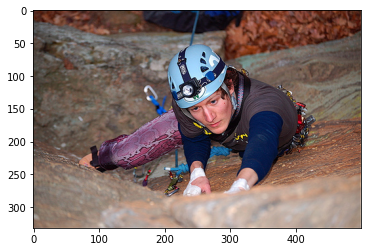

In [12]:
img_path = '/Users/anjalisingh/Documents/ImageCaptionGenerator/Flicker8k_Dataset/111537222_07e56d5a30.jpg'
def extract_features(filename, model):
        try:
            image = Image.open(filename)
        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text
#path = 'Flicker8k_Dataset/111537222_07e56d5a30.jpg'
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('IMageCG.h5')
xception_model = Xception(include_top=False, pooling="avg")
photo = extract_features(img_path, xception_model)
img = Image.open(img_path)
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)